# Lab Vision Sytems: Session 7

# Today:

### 1: Solution Assignment 6
### 2: Deep Metric Learning

# 0. Announcements

## Seminar Vision Systems

 - Review a very recent high-quality paper
 - Present it to a scientific audience
 - **Intro Meeting**: Friday 07.02.2025 at 12:00 in room 0.016

<img src="./resources/seminar.png" width=58%><img src="./resources/paper_list.png" width=40%>

# 1. Solution Assignment 6

Today by Pallavi & Salvin

# 2. Deep Metric Learning

In [1]:
import os
import random
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
a = torch.ones(1).cuda()

In [3]:
torch.cuda.is_available()

True

## Dataset

In [4]:
# Downloading and Loading Dataset
mnist_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2),
    ])

# train + valid splits
dataset = datasets.FashionMNIST(root='./data', train=True, transform=mnist_tf,download=True)
train_img_dataset, val_img_dataset = torch.utils.data.random_split(dataset, [50000, 10000])

# eval set
test_img_dataset = datasets.FashionMNIST(root='./data', train=False, transform=mnist_tf)

In [5]:
class TripletDataset:
    """
    Dataset class from which we sample random triplets
    """
    def __init__(self, dataset):
        """ Dataset initializer"""
        self.dataset = dataset
        self.arange = np.arange(len(dataset))
        self.labels = torch.Tensor([l for _,l in dataset])
        return
    
    def __len__(self):
        """ Returning number of anchors """
        return len(self.dataset)

    def __getitem__(self, i):
        """ 
        Sampling a triplet for the dataset. Index i corresponds to anchor 
        """
        # sampling anchor
        anchor_img, anchor_lbl = self.dataset[i]

        # lists for positives and negatives
        pos_ids = self.arange[torch.where(self.labels == anchor_lbl)]
        neg_id = self.arange[torch.where(self.labels != anchor_lbl)]
        
        # random positive and negative
        # BIG FLAW HERE! 
        pos_id, neg_id = random.choice(pos_ids).item(), random.choice(neg_id).item()  # BIG FLAW HERE! 
        pos_img, pos_lbl = self.dataset[pos_id] 
        neg_img, neg_lbl = self.dataset[neg_id]
              
        return (anchor_img, pos_img, neg_img), (anchor_lbl, pos_lbl, neg_lbl)

In [6]:
train_dataset = TripletDataset(train_img_dataset)
val_dataset = TripletDataset(val_img_dataset)
test_dataset = TripletDataset(test_img_dataset)

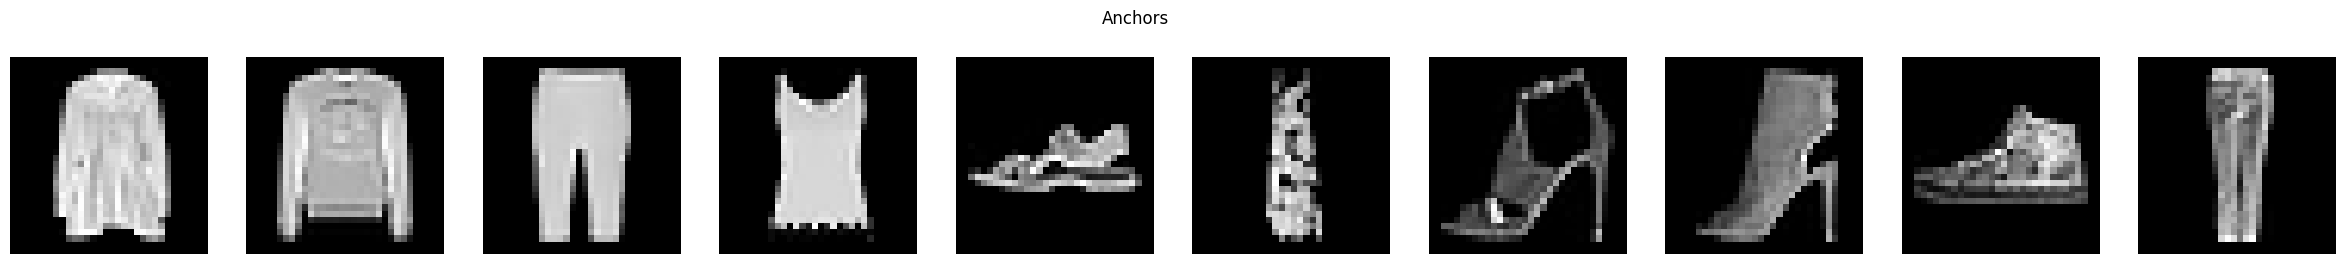

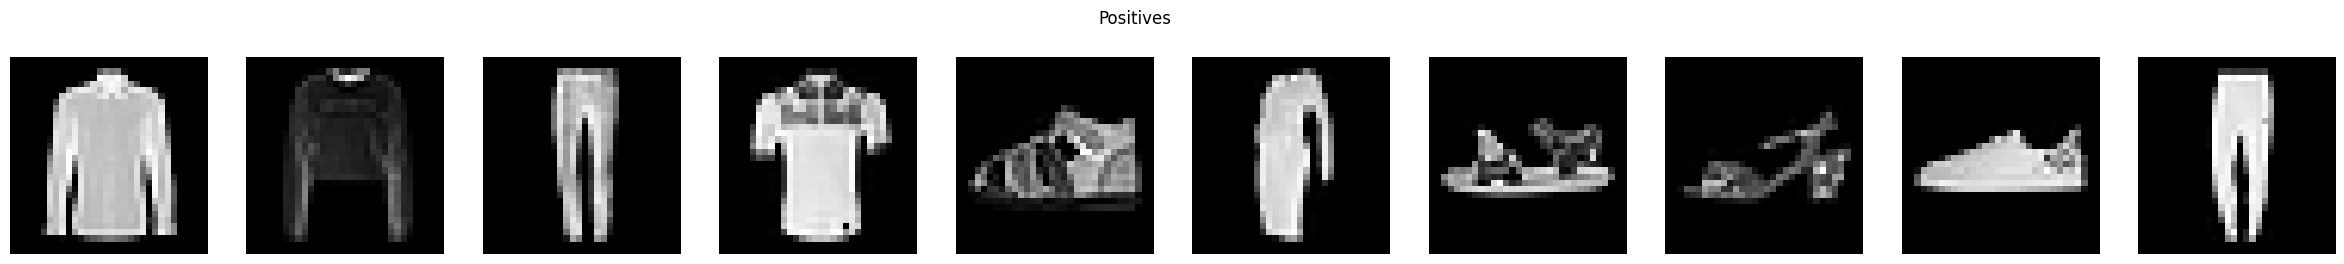

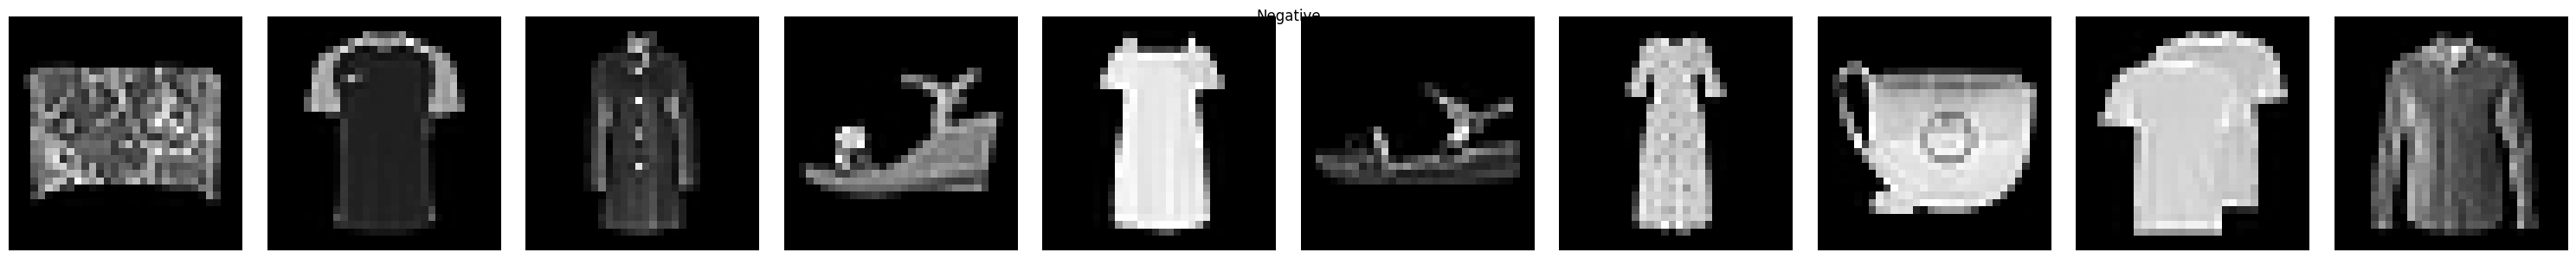

In [7]:
fig_anchors, anchors = plt.subplots(1, 10, figsize=(30,3))
fig_pos, positives = plt.subplots(1, 10, figsize=(30,3))
fig_neg, negatives = plt.subplots(1, 10, figsize=(30,3))
for i in range(10):
    (anchor, positive, negative), _ = val_dataset[i]
    anchors[i].imshow(anchor[0], cmap="gray")
    anchors[i].axis("off")
    positives[i].imshow(positive[0], cmap="gray")
    positives[i].axis("off")
    negatives[i].imshow(negative[0], cmap="gray")
    negatives[i].axis("off")
fig_anchors.suptitle("Anchors")
fig_pos.suptitle("Positives")
fig_neg.suptitle("Negative")
plt.tight_layout()
plt.show()

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False) 

## Utils

In [9]:
# utils

def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def save_model(model, optimizer, epoch, stats, margin):
    """ Saving model checkpoint """
    
    if(not os.path.exists("checkpoints")):
        os.makedirs("checkpoints")
    savepath = f"checkpoints/checkpoint_epoch_{epoch}_margin_{margin}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath, map_location="cpu")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

def visualize_progress(train_loss, val_loss, start=0):
    """ Visualizing loss and accuracy """
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)

    smooth_train = smooth(train_loss, 31)
    ax[0].plot(train_loss, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_train, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_yscale("linear")
    ax[0].set_title("Training Progress (linear)")
    
    ax[1].plot(train_loss, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[1].plot(smooth_train, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_yscale("log")
    ax[1].set_title("Training Progress (log)")

    smooth_val = smooth(val_loss, 31)
    N_ITERS = len(val_loss)
    ax[2].plot(np.arange(start, N_ITERS)+start, val_loss[start:], c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[2].plot(np.arange(start, N_ITERS)+start, smooth_val[start:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Iteration")
    ax[2].set_ylabel("CE Loss")
    ax[2].set_yscale("log")
    ax[2].set_title(f"Valid Progress")

    return

def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
              'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")


## Siamese Model

In [11]:
class NormLayer(nn.Module):
    """ Layer that computer embedding normalization """
    def __init__(self, l=2):
        """ Layer initializer """
        assert l in [1, 2]
        super().__init__()
        self.l = l
        return
    
    def forward(self, x):
        """ Normalizing embeddings x. The shape of x is (B,D) """
        x_normalized = x / torch.norm(x, p=self.l, dim=-1, keepdim=True)
        return x_normalized

In [12]:
class ConvBlock(nn.Module):
    """ Building block with 2 convolutions """
    
    def __init__(self, in_channels, out_channels, kernel_size):
        """ """
        super().__init__()
        padding = kernel_size // 2
        self.block = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
    
    def forward(self, x):
        """ """
        y = self.block(x)
        return y

class SiameseModel(nn.Module):
    """ 
    Implementation of a simple siamese model 
    """
    def __init__(self, emb_dim=32, channels=[1, 32, 64, 128], in_spatial=(32, 32)):
        """ Module initializer """
        super().__init__()
        n_layers = len(channels) - 1
        
        # convolutional feature extractor
        cnn = []
        for i in range(n_layers):
            cnn.append( ConvBlock(in_channels=channels[i], out_channels=channels[i+1], kernel_size=3) )
        self.cnn = nn.Sequential(*cnn)
        
        # fully connected embedder
        flat_dim = int(channels[-1] * (in_spatial[0] / (2**n_layers)) * (in_spatial[0] / (2**n_layers)))
        self.fc = nn.Linear(flat_dim, emb_dim)
        
        # auxiliar layers
        self.flatten = nn.Flatten()
        self.norm = NormLayer()
    
        return
    
    def forward_one(self, x):
        """ Forwarding just one sample through the model """
        x = self.cnn(x)
        x_flat = self.flatten(x)
        x_emb = self.fc(x_flat)
        x_emb_norm = self.norm(x_emb)
        return x_emb_norm
    
    def forward(self, anchor, positive, negative):
        """ Forwarding a triplet """
        anchor_emb = self.forward_one(anchor)
        positive_emb = self.forward_one(positive)
        negative_emb = self.forward_one(negative)
        
        # is there a more efficient way?
        # all_imgs = torch.cat([anchor, positive, negative], dim=0)
        # anchor_emb = self.forward_one(all_imgs)
        # anchor_emb, positive_emb, negative_emb = torch.chunk(all_embs, embs, 3, dim=0)
        
        return anchor_emb, positive_emb, negative_emb

In [13]:
model = SiameseModel()

In [14]:
print(f"Model has {count_model_params(model)} parameters")
model

Model has 352896 parameters


SiameseModel(
  (cnn): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU()
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(64

## Training

In [15]:
class TripletLoss(nn.Module):
    """ Implementation of the triplet loss function """
    def __init__(self, margin=0.2, reduce="mean"):
        """ Module initializer """
        assert reduce in ["mean", "sum"]
        super().__init__()
        self.margin = margin
        self.reduce = reduce
        return
        
    def forward(self, anchor, positive, negative):
        """ Computing pairwise distances and loss functions """
        # L2 distances
        d_ap = (anchor - positive).pow(2).sum(dim=-1)
        d_an = (anchor - negative).pow(2).sum(dim=-1)
        
        # triplet loss function
        loss = (d_ap - d_an + self.margin)
        loss = torch.maximum(loss, torch.zeros_like(loss))
        
        # averaging or summing      
        loss = torch.mean(loss) if(self.reduce == "mean") else torch.sum(loss)
      
        return loss

In [16]:
class Trainer:
    """
    Class for training and validating a siamese model
    """
    
    def __init__(self, model, criterion, train_loader, valid_loader, n_iters=1e4):
        """ Trainer initializer """
        self.model = model
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        
        self.n_iters = int(n_iters)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        self.train_loss = []
        self.valid_loss = []
        return
    
    @torch.no_grad()
    def valid_step(self, val_iters=100):
        """ Some validation iterations """
        self.model.eval()
        cur_losses = []
        for i, ((anchors, positives, negatives),_) in enumerate(self.valid_loader):   
            # setting inputs to GPU
            anchors = anchors.to(self.device)
            positives = positives.to(self.device)
            negatives = negatives.to(self.device)
            
            # forward pass and triplet loss
            anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
            loss = self.criterion(anchor_emb, positive_emb, negative_emb)
            cur_losses.append(loss.item())
            
            if(i >= val_iters):
                break
    
        self.valid_loss += cur_losses
        self.model.train()
        
        return cur_losses
    
    def fit(self):
        """ Train/Validation loop """
    
        self.iter_ = 0
        progress_bar = tqdm(total=self.n_iters, initial=0)
        
        for i in range(self.n_iters):
            for (anchors, positives, negatives), _ in self.train_loader:     
                # setting inputs to GPU
                anchors = anchors.to(self.device)
                positives = positives.to(self.device)
                negatives = negatives.to(self.device)
                
                # forward pass and triplet loss
                anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
                loss = self.criterion(anchor_emb, positive_emb, negative_emb)
                self.train_loss.append(loss.item())
                
                # optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
                # updating progress bar
                progress_bar.set_description(f"Train Iter {self.iter_}: Loss={round(loss.item(),5)})")
                
                # doing some validation every once in a while
                if(self.iter_ % 250 == 0):
                    cur_losses = self.valid_step()
                    print(f"Valid loss @ iteration {self.iter_}: Loss={np.mean(cur_losses)}")
                
                self.iter_ = self.iter_+1 
                if(self.iter_ >= self.n_iters):
                    break
            if(self.iter_ >= self.n_iters):
                break
        return

In [17]:
model = SiameseModel()
criterion = TripletLoss(margin=0.2)

In [18]:
trainer = Trainer(model=model, criterion=criterion, train_loader=train_loader, valid_loader=valid_loader, n_iters=1000)

In [19]:
trainer.fit()

Train Iter 2: Loss=0.0656):   0%|          | 0/1000 [00:04<?, ?it/s] 

Valid loss @ iteration 0: Loss=0.19962552957015461


Train Iter 252: Loss=0.03317):   0%|          | 0/1000 [00:27<?, ?it/s]

Valid loss @ iteration 250: Loss=0.027429050968793948


Train Iter 502: Loss=0.00385):   0%|          | 0/1000 [00:51<?, ?it/s]

Valid loss @ iteration 500: Loss=0.025348190912091645


Train Iter 752: Loss=0.01141):   0%|          | 0/1000 [01:14<?, ?it/s]

Valid loss @ iteration 750: Loss=0.021479962361367917


Train Iter 999: Loss=0.02011):   0%|          | 0/1000 [01:33<?, ?it/s]


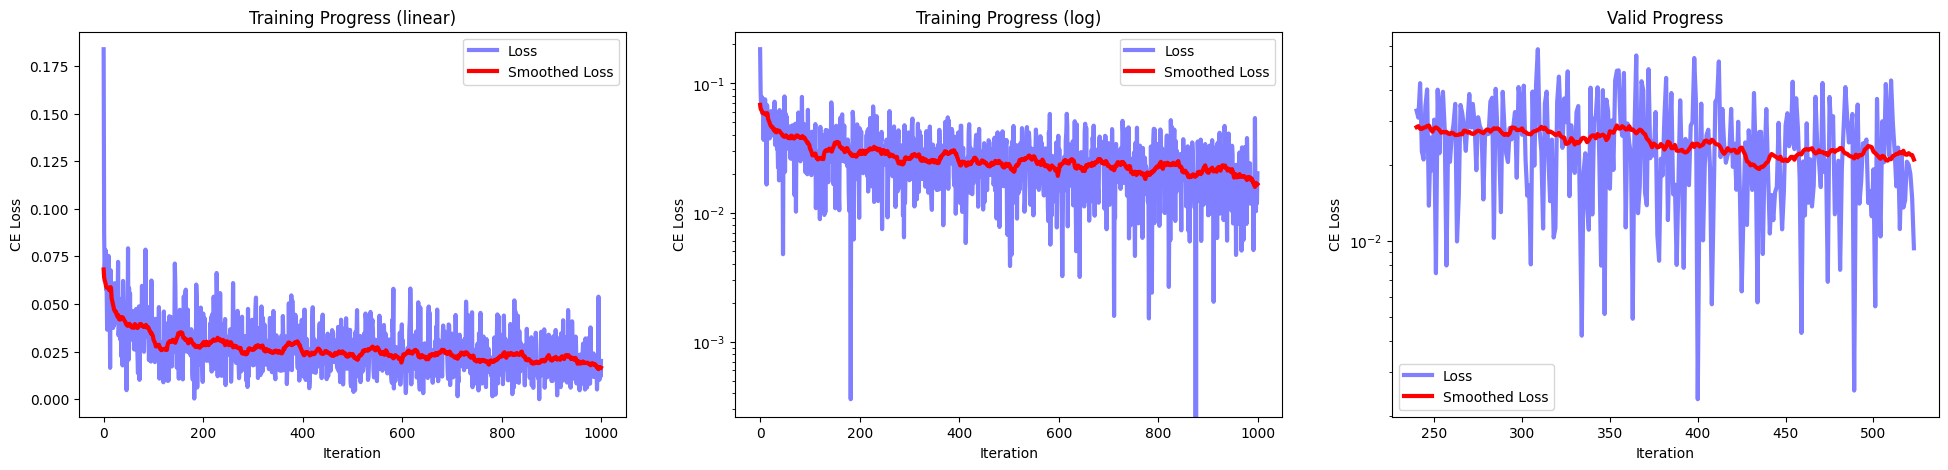

In [20]:
visualize_progress(trainer.train_loss, trainer.valid_loss, start=120)
plt.show()

In [21]:
stats = {
    "train_loss": trainer.train_loss,
    "valid_loss": trainer.valid_loss
}
save_model(trainer.model, trainer.optimizer, trainer.iter_, stats, margin=0.2)

### Loading a model trained for 10,000 iterations

In [35]:
model, optimizer, epoch, stats = load_model(trainer.model, trainer.optimizer, savepath="_checkpoints/checkpoint_epoch_10000.pth")
# model, optimizer, epoch, stats = load_model(trainer.model, trainer.optimizer, savepath="checkpoints/checkpoint_epoch_1000_margin_0.001.pth")
# model, optimizer, epoch, stats = load_model(trainer.model, trainer.optimizer, savepath="checkpoints/checkpoint_epoch_1000_margin_0.2.pth")
# model, optimizer, epoch, stats = load_model(trainer.model, trainer.optimizer, savepath="checkpoints/checkpoint_epoch_1000_margin_0.5.pth")

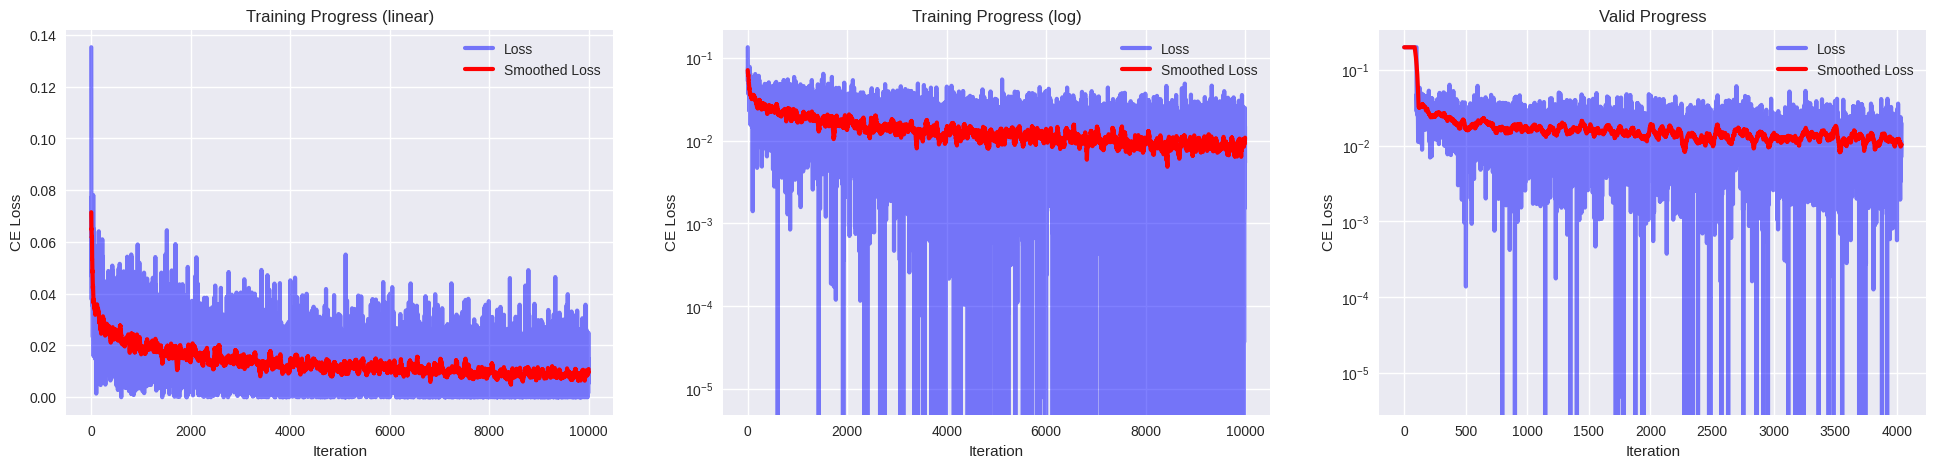

In [36]:
visualize_progress(stats["train_loss"], stats["valid_loss"], start=0)
plt.show()

## Visualizing Embeddings

In [37]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [38]:
# model = trainer.model
device = trainer.device
model = model.eval()

In [39]:
(img,_,_),(lbl,_,_) = next(iter(test_loader))

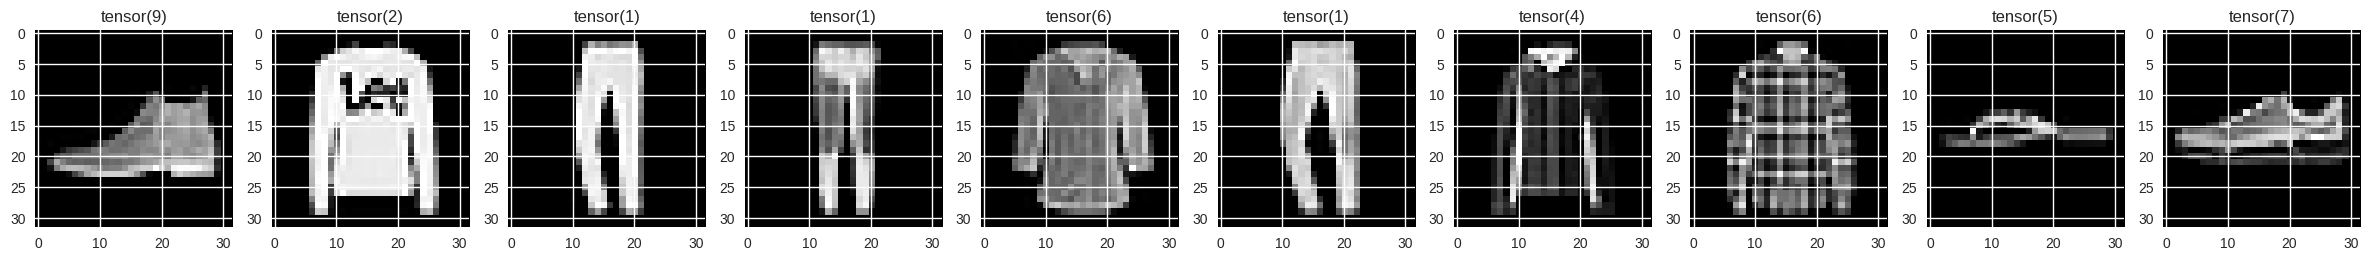

In [40]:
fig, ax = plt.subplots(1,10, figsize=(30,3))
for i in range(10):
    ax[i].imshow(img[i,0], cmap="gray")
    ax[i].set_title(lbl[i])
plt.show()

In [41]:
imgs_flat = []
embs = []
labels = []
with torch.no_grad():
    for (anchor, _, _), (lbl,_, _) in test_loader:
        anchor = anchor.to(device)
        anchor_emb = model.forward_one(anchor)
        
        labels.append(lbl)
        embs.append(anchor_emb.cpu())
        imgs_flat.append(anchor.cpu().flatten(1))

labels = np.concatenate(labels)
embs = np.concatenate(embs)
imgs_flat = np.concatenate(imgs_flat)

In [42]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_embs = PCA(n_components=2).fit_transform(embs)

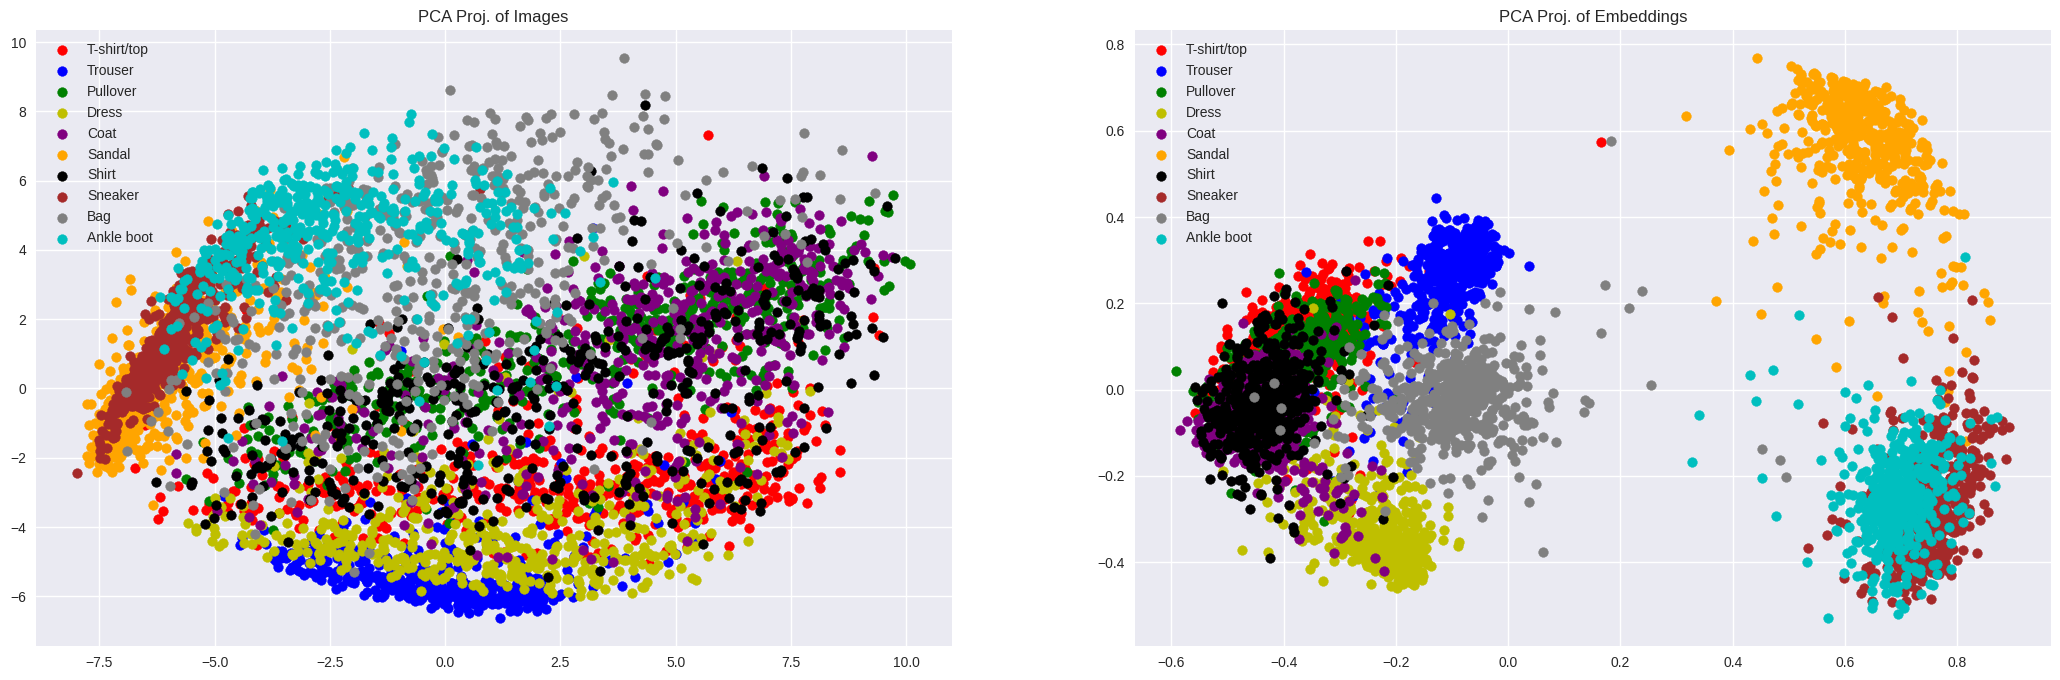

In [43]:
N = 5000
plt.style.use('seaborn')
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.dataset.classes)
ax[0].set_title("PCA Proj. of Images")
display_projections(pca_embs[:N], labels[:N], ax=ax[1], legend=test_dataset.dataset.classes)
ax[1].set_title("PCA Proj. of Embeddings")
plt.show()

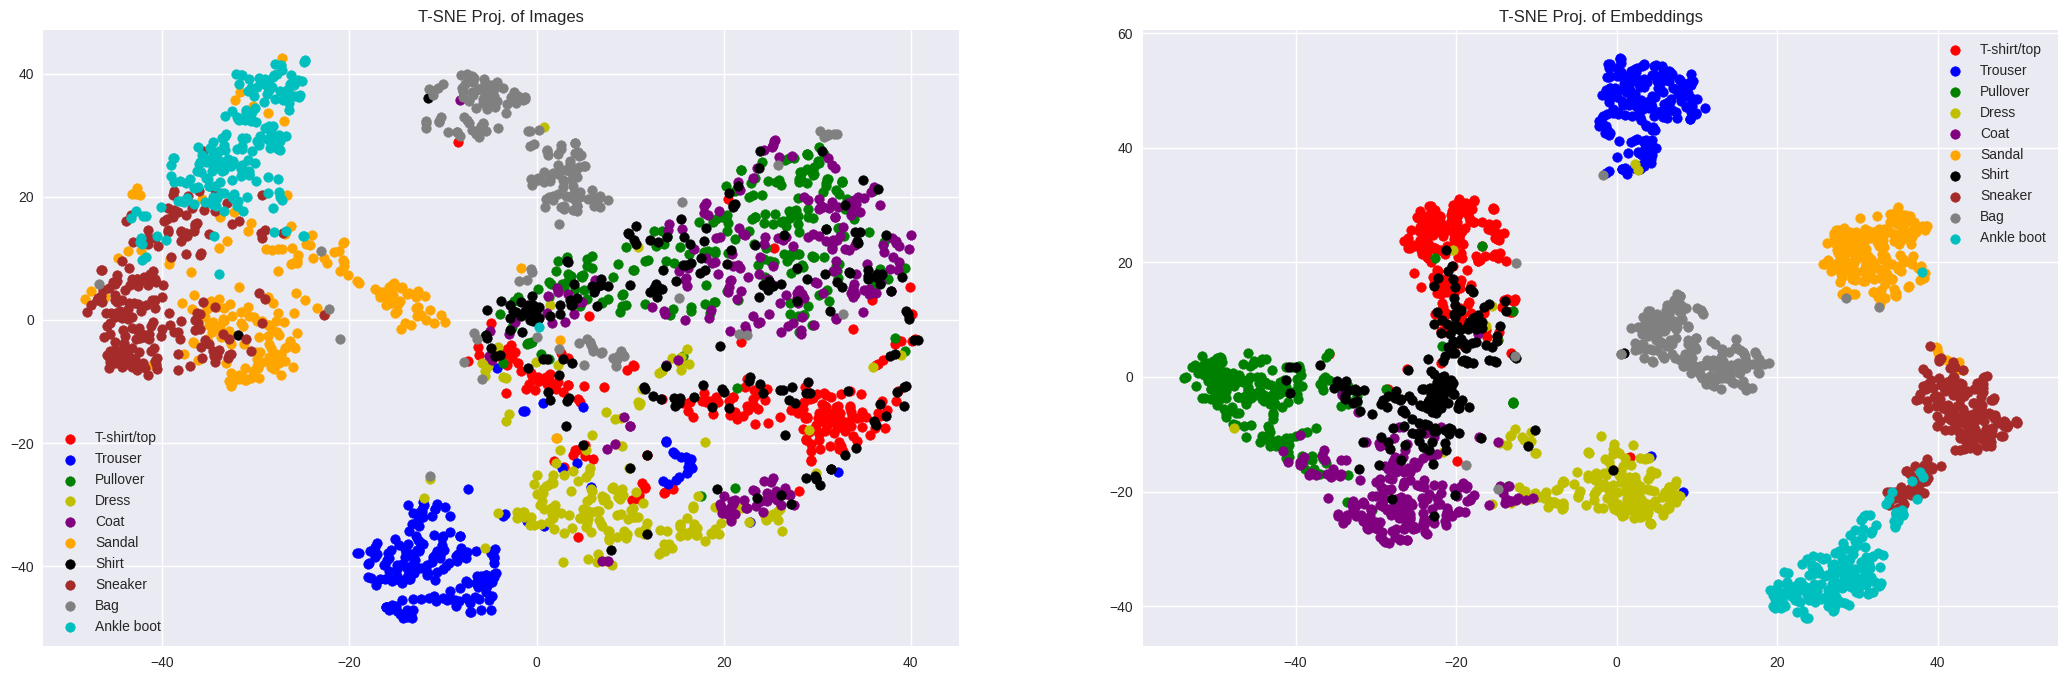

In [44]:
N = 2000
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_embs = TSNE(n_components=2).fit_transform(embs[:N])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.dataset.classes)
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_embs[:N], labels[:N], ax=ax[1], legend=test_dataset.dataset.classes)
ax[1].set_title("T-SNE Proj. of Embeddings")
plt.show()

## Clustering

In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [46]:
kmeans_imgs = KMeans(n_clusters=10, random_state=0).fit(imgs_flat)
kmeans_embs = KMeans(n_clusters=10, random_state=0).fit(embs)

/home/villar/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/villar/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [47]:
ari_imgs = adjusted_rand_score(labels, kmeans_imgs.labels_)
ari_embs = adjusted_rand_score(labels, kmeans_embs.labels_)

In [48]:
print(f"Clustering images achieves  ARI={round(ari_imgs*100,2)}%")
print(f"Clustering embeddings achieves ARI={round(ari_embs*100,2)}%")

Clustering images achieves  ARI=34.98%
Clustering embeddings achieves ARI=81.86%


In [49]:
print(f"Compression ratio: {embs.shape[-1]}/{imgs_flat.shape[-1]}  = {round(embs.shape[-1]/imgs_flat.shape[-1] * 100, 2)}%")

Compression ratio: 32/1024  = 3.12%


#### When clustering using the latent codes from an autoencoder, we achieved a 37% accuracy. However, today we double that performance.

#### Why is that?

## Nice Visualization

In [50]:
def display_projections_images(points, labels, dataset, ax=None, legend=None):
    """ Displaying low-dimensional data projections using images instead of points """
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
              'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    _, ax = plt.subplots(1,1,figsize=(36,24))
    
    for l in np.unique(labels):
        idx = np.where(l==labels)
        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], color=COLORS[l]) 

    for i, point in enumerate(points):
        xy = [point[0], point[1]]
        
        arr_img = dataset[i][0][0][0]
        l = labels[i]
        imagebox = OffsetImage(arr_img, zoom=1)
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            pad=0.1,
                            bboxprops=dict(edgecolor=COLORS[l], lw=2)
                            )

        ax.add_artist(ab)
    ax.legend(loc="best")
    plt.show()

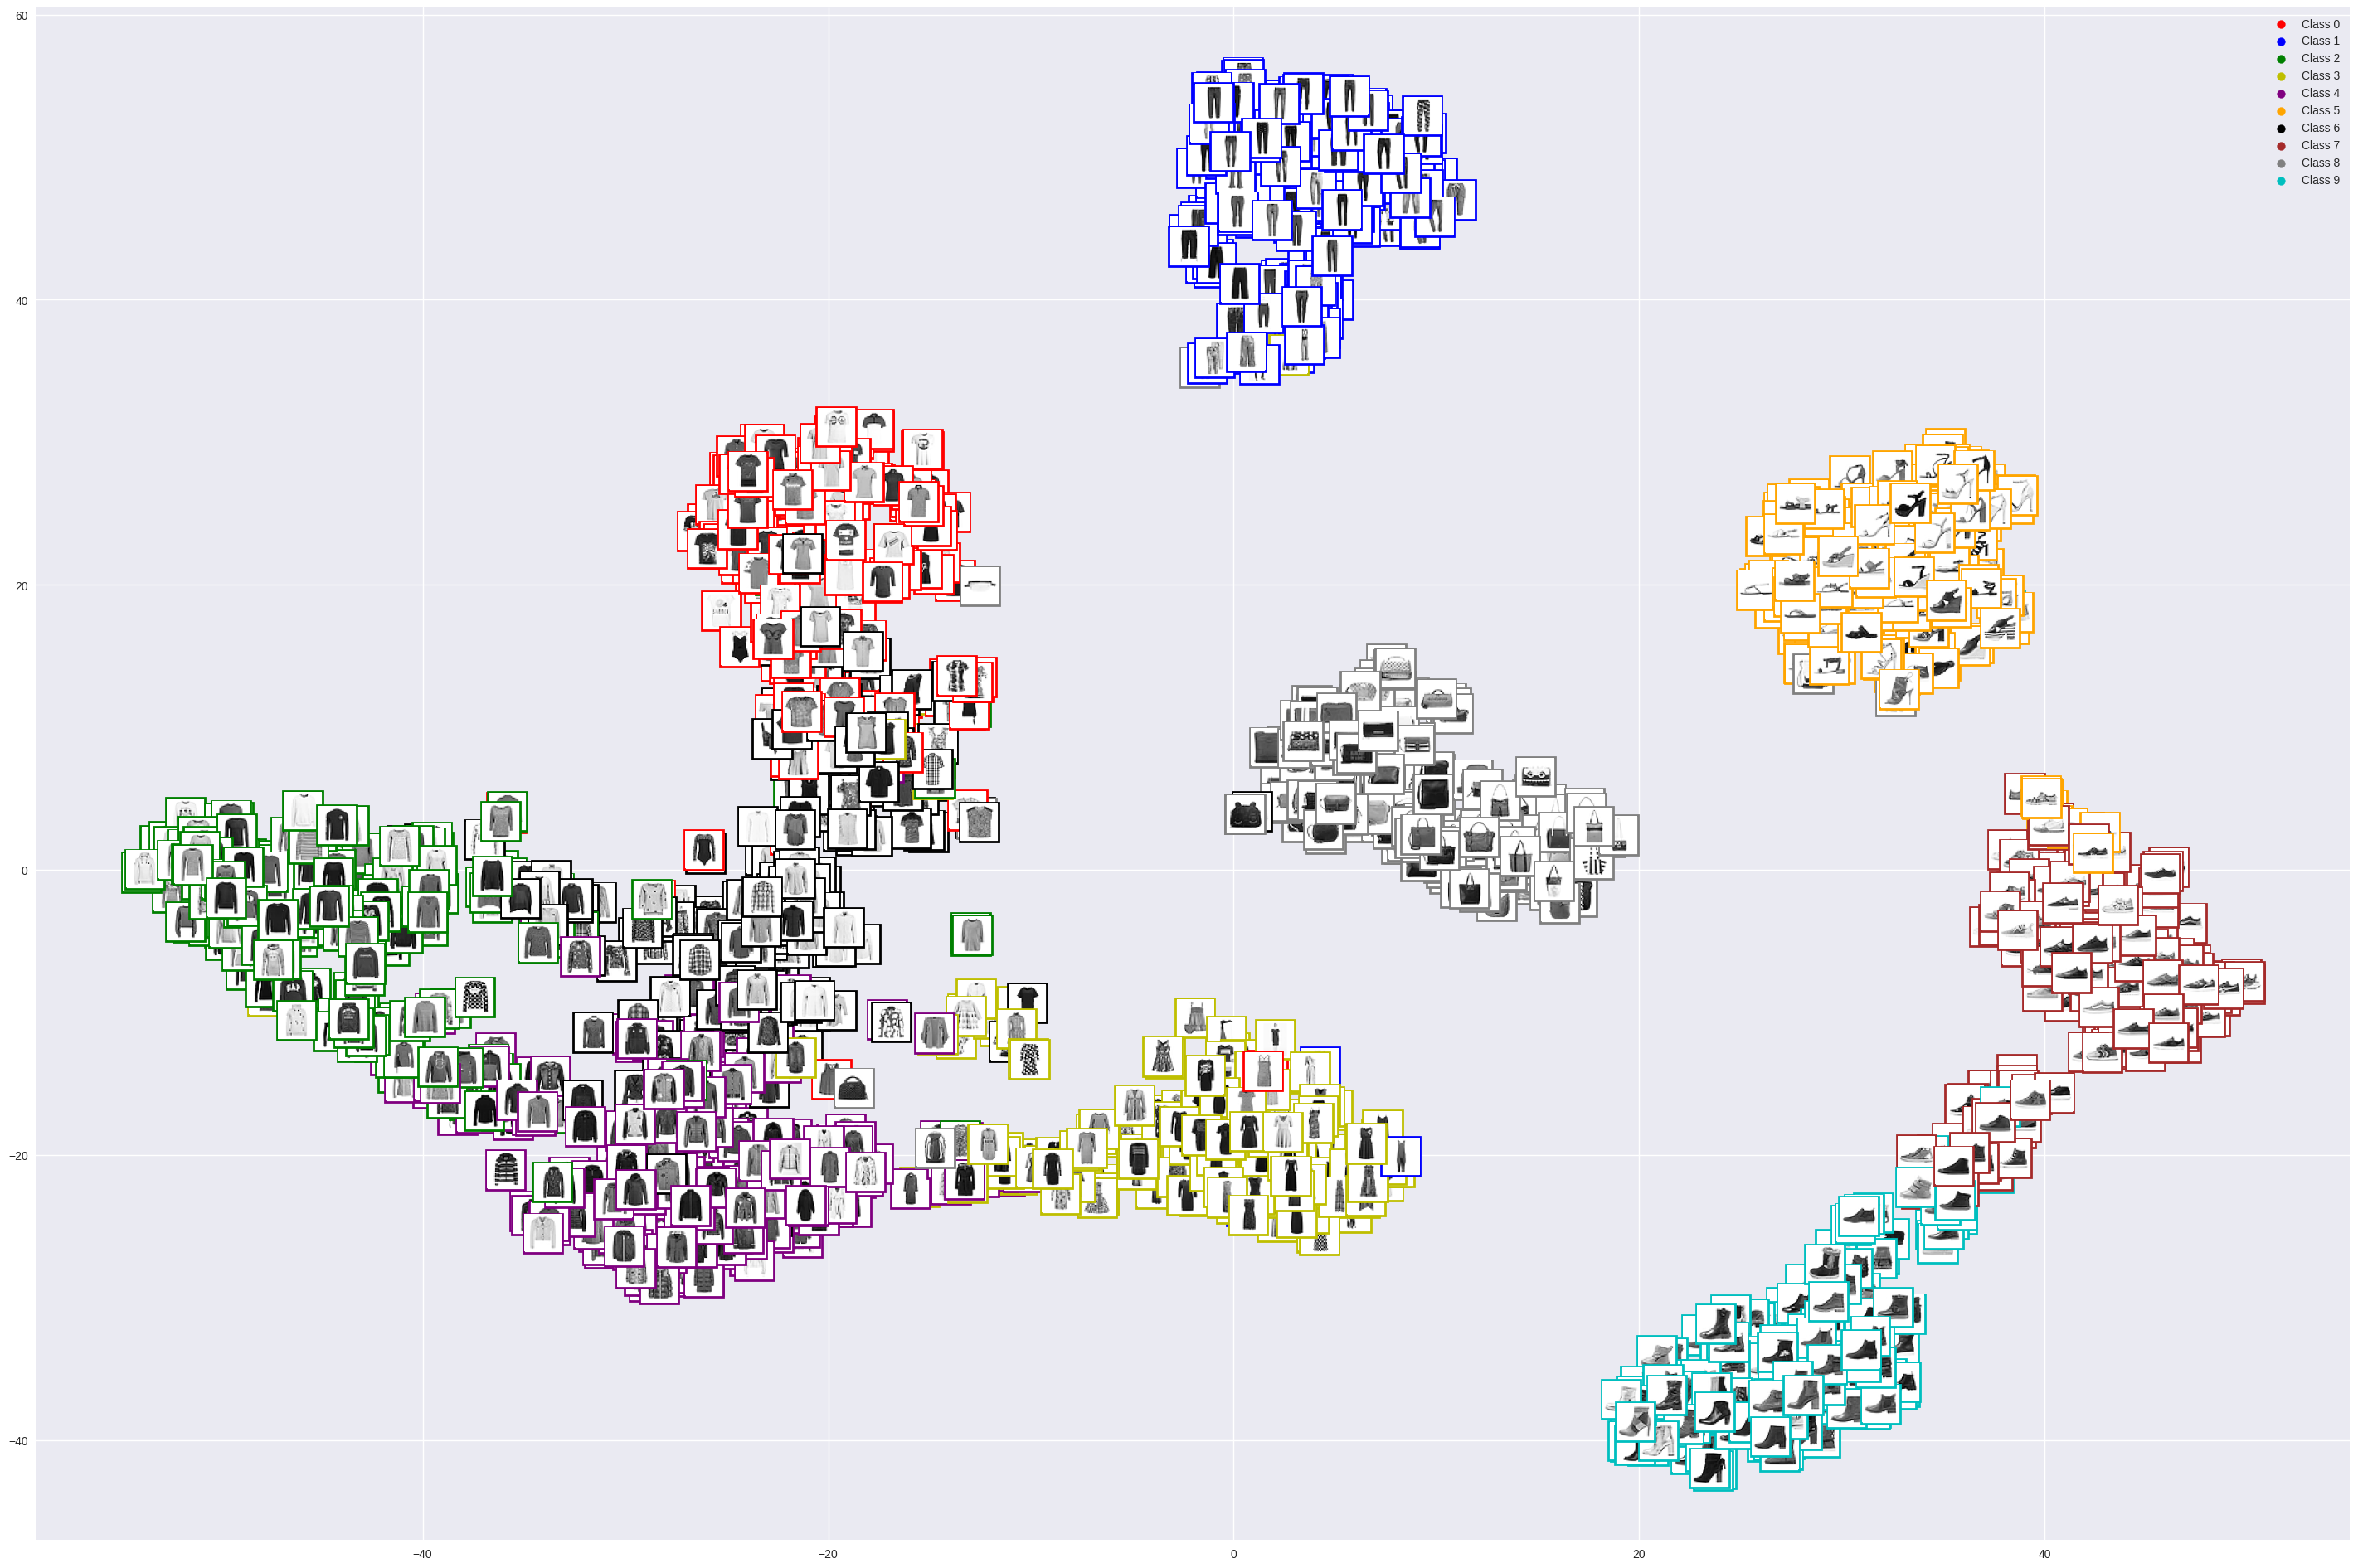

In [51]:
display_projections_images(points=tsne_embs[:2000], labels=labels[:2000], dataset=test_dataset)

# Assignment 7

 - Implement the (adapted) TriNet Siamese model:
    - ResNet18 convolutional backbone (until AvgPool) 
    - Fully connected frontend to obtain desired embedding
    - Normalization layer
 - Use *Labeled Faces in the Wild* (LFW) dataset (http://vis-www.cs.umass.edu/lfw/)
    - Over 13000 images
    - Train and test set
 - Train and Evaluate TriNet for some different margin values (e.g. 0, 0.2, 0.5, 1.0)
    - How does this hyper-param affect the performance of your model?
    - Which models work well or do not work?
 - Evaluate and compare the model performance (need not be thorough)
 - Visualize embeddings (not necessary for all classes, e.g. pick the 10 classes with the most images)
 - **Extra Point**:
     - Take one or a few images/selfies from the members in your group. Try to use different iluminations, angles, ...
     - Does your model predict similar embeddings for your images?
     - How similar are you with your group partner?
     - To which celebrity does your model think you look like?

#### **Due Date**: Tuesday 28.01.2025 @ 23:59
#### Submit it by mail using the subject: **CudaLab: Assignment7 + Group Name**
####  Send me the following: Jupyter Notebook after running, Jupyter export as **html**, any other .py files or images used.

#### **Next Session:** Wednesday 29.01.2025. Room 0.016 from 14:00-16:00

# References
 - https://www.deeplearningbook.org/
 - https://towardsdatascience.com/all-you-want-to-know-about-deep-learning-8d68dcffc258
 - https://www.youtube.com/watch?v=6e65XfwmIWE

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
    <b>Angel Villar-Corrales</b><br>
    <ul>
       <li> <b>Email</b>: villar@ais.uni-bonn.de
       <li> <b>Website</b>: angelvillarcorrales.com
    </ul>
</div>  